In [17]:
# import dependencies 
import numpy as np
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, log_loss, \
    precision_score, recall_score, precision_recall_curve, average_precision_score
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import os
from xgboost import XGBClassifier
%matplotlib inline 

# Load Data

In [18]:
# define folder where data resides 
DATAFOLDER = "~/Documents/data-science-coursework/nyu-ml/project/"

In [19]:
# function to load data 
def load_data(filename, root_path=DATAFOLDER):
    csv_path = os.path.join(root_path, filename)
    df = pd.read_csv(csv_path)
    return df 

In [20]:
# load data 
df = load_data(filename="data_for_model/appeals_data_final.csv", root_path=DATAFOLDER)
df.set_index('idnAppeal', inplace=True) 
print(df.info()) 
print(df.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
Float64Index: 242466 entries, 4657002.0 to 5021568.0
Columns: 231 entries, idncase to last_10_appeal_grant_by_judge_nat
dtypes: bool(1), float64(96), int64(41), object(93)
memory usage: 427.6+ MB
None
['idncase', 'idnproceeding', 'nat', 'case_type', 'c_asy_type', 'base_city_code', 'hearing_loc_code', 'dec_type', 'dec_code', 'other_comp', 'attorney_flag', 'ij_code', 'tracid', 'case_type_string', '_mcase', 'original_dec_type_string', '_mdectype', 'outcome_recorded_in_field', 'original_dec_string', '_mdecproceeddec', '_mdecproceedoth', 'nat_string', '_mnat', 'base_city_street', 'base_city_string', 'base_city_state', 'base_city_zip5', 'base_city_zip4', 'base_city_phone', '_mbasecity', 'hearing_loc_string1', 'hearing_loc_string2', 'hearing_loc_street', 'hearing_loc_city', 'hearing_loc_state', 'hearing_loc_zip5', 'hearing_loc_phone', '_mhearingloc', 'judge_name_caps', '_mlookupijcode', 'idncode', 'idnproceedingappln', 'appl_code', 'appl_dec', '_mappln', 

# Data Pipelines

In [21]:
# impute missing data

def impute_columns_udf(col, imputation_type): 
    """ 
    UDF to specify imputation method for a given variable. 
    col is the pd.Series for which you want to impute, imputation_type should be chosen from 
    ['mode', 'mean', 'median', 'zero', 'none'] 
    """ 
    if imputation_type == 'mode':
        val = col.mode()[0]
        return col.fillna(val)
    
    elif imputation_type == 'mean': 
        val = col.mean() 
        return col.fillna(val)
    
    elif imputation_type == 'median': 
        val = col.median() 
        return col.fillna(val)
    
    elif imputation_type == 'zero': 
        return col.fillna(0)
    
    elif imputation_type == 'none':
        return col.fillna('None')
    
    else: 
        raise ValueError('imputation_type argument not valid')

class ImputeMissingData(BaseEstimator, TransformerMixin):
    """ Pipeline step that impute missing values, given impute methods specified. 
        Note that numerical features with NaN's and no impute methods will raise an error, 
        categorical features on the other hand will be filled with 'None' by default unless specified otherwise.
    """
    def __init__(self, impute_methods, num_features, cat_features): 
        self.impute_methods = impute_methods
        self.num_features = num_features
        self.cat_features = cat_features
    
    def fit(self, X, y=None): 
        return self 
    
    def transform(self, input_data): 
        output_data = input_data.copy() 

        # check which features have missing values but imputation methods not specified 
        features_nulls = output_data.isnull().sum() 
        features_nulls = features_nulls[features_nulls > 0].index.tolist() 
        features_need_impute = [f for f in features_nulls if f not in self.impute_methods.keys()]
        num_features_need_impute = [f for f in features_need_impute if f in self.num_features]
        cat_features_need_impute = [f for f in features_need_impute if f in self.cat_features]
        
        # raise exception for numerical features with missing values and no imputation method specified 
        if num_features_need_impute: 
            raise Exception("""These numerical features have missing values: {}. 
            Please specify their impute methods.""".format(num_features_need_impute)) 
        
        # set imputation method as 'none' for cat features with missing values with no imputation method specified 
        if cat_features_need_impute: 
            for cat_f in cat_features_need_impute: 
                self.impute_methods[cat_f] = 'none'
            print("""{} have missing values with no imputation method specified. 
            By default, they have been filled with 'None'.""".format(cat_features_need_impute)) 
                
        # apply imputations 
        for col, imp_method in self.impute_methods.items(): 
            output_data[col] = impute_columns_udf(output_data[col], imp_method)
            
        return output_data 

In [22]:
# convert data types
class ConvertDataTypes(BaseEstimator, TransformerMixin): 
    """ Coerce data types to specifications defined by CAT_FEATURES and NUM_FEATURES """
    def __init__(self, num_features, cat_features): 
        self.num_features = num_features 
        self.cat_features = cat_features
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, input_data): 
        output_data = input_data.copy() 
        output_data[self.num_features] = output_data[self.num_features].astype(float)
        output_data[self.cat_features] = output_data[self.cat_features].astype(str)
        return output_data 

In [23]:
# dummify data 

class Dummify(BaseEstimator, TransformerMixin): 
    """ Pipeline step that dummifies all categorical variables """
    def __init__(self, cat_feature_values): 
        self.cat_feature_values = cat_feature_values
    
    def fit(self, X, y=None): 
        return self
    
    def transform(self, input_data):
        output_data = input_data.copy()
        # specify values categorical features can take on, to ensure train/test DF have same cols 
        cat_features = self.cat_feature_values.keys()
        for col in cat_features: 
            output_data[col] = pd.Categorical(output_data[col], categories=self.cat_feature_values[col])        
        output_data = pd.get_dummies(output_data, columns=cat_features, prefix_sep=':::')
        return output_data

# Model Methods

In [24]:
# method to subset and transform data (impute, convert, dummify)

def transform_features(data, df, cat_features, num_features, impute_methods): 
    """ Impute, convert and dummify features 
        TODO: save cat_feature_values to pickle so that we don't have to read df 
    """  
    
    # subsets features we are interested in 
    cat_feature_values = dict([(f, [str(x) for x in df[f].dropna().unique().tolist()]) for f in cat_features])
    data = data[cat_features + num_features].copy() 

    # make pipeline 
    data_pipeline = Pipeline([
        ('impute', ImputeMissingData(impute_methods, num_features, cat_features)),         
        ('convert_dtypes', ConvertDataTypes(num_features, cat_features)), 
        ('dummify', Dummify(cat_feature_values))
    ])
    
    # run pipeline 
    X = data_pipeline.fit_transform(data)
    
    return X

# method to split train-test and transform features 

def get_model_data(df, label, cat_features, num_features, impute_methods, test_size=0.2, print_summary=False): 
    """ Subsets features used, splits into train-test, and transforms features """
    
    # subsets features we are interested in 
    data = df[cat_features + num_features + [label]].copy() 
    
    # train test split 
    X, y = data.drop(label, axis=1).copy(), data[label].copy() 
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=44)

    # transform features
    X_train = transform_features(x_train, df, cat_features, num_features, impute_methods)
    X_test = transform_features(x_test, df, cat_features, num_features, impute_methods)

    if print_summary:
        print("Training Data: {} | Test Data: {}".format(X_train.shape, X_test.shape)) 
    
    return X_train, X_test, y_train, y_test 

In [25]:
# # method to subset data for training model - DEPRECATE - doesn't work on pure prediction data 
# def get_model_data(df, label, cat_features, num_features, impute_methods, test_size=0.2, print_summary=False): 
#     """ Subsets variables used for model, runs it through pipeline to output data for model 
#         Set test_size = 0 if generating data only for prediction 
#         (TODO: IF HAVE TIME SPLIT INTO SEPARATE FUNCTION)
#     """
    
#     # subsets features we are interested in 
#     cat_feature_values = dict([(f, [str(x) for x in df[f].dropna().unique().tolist()]) for f in cat_features]) # do EDA and limit to smaller list
#     data = df[cat_features + num_features + [label]].copy() 
    
#     # train test split 
#     X, y = data.drop(label, axis=1).copy(), data[label].copy() 
#     x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=44)
    
#     # make pipeline 
#     data_pipeline = Pipeline([
#         ('impute', ImputeMissingData(impute_methods, num_features, cat_features)),         
#         ('convert_dtypes', ConvertDataTypes(num_features, cat_features)), 
#         ('dummify', Dummify(cat_feature_values))
#     ])
    
#     # run pipeline 
#     X_train = data_pipeline.fit_transform(x_train)
#     X_test = data_pipeline.transform(x_test)
#     if print_summary:
#         print("Training Data: {} | Test Data: {}".format(X_train.shape, X_test.shape)) 
    
#     return X_train, X_test, y_train, y_test 

In [26]:
# method to return model evaluation metrics 
def evaluate_model(truth, pred): 
    """ Takes in arrays of truth and pred y values and return accuracy, logloss, roc_auc, and plot ROC """ 
    accuracy = accuracy_score(truth, (pred>0.5).astype(int))
    logloss = log_loss(truth, pred)
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    precision = precision_score(truth, (pred>0.5).astype(int))
    recall = recall_score(truth, (pred>0.5).astype(int))
    metrics = {'Accuracy': accuracy, 'ROC AUC': roc_auc, 'Log Loss': logloss, 
               'Precision': precision, 'Recall': recall}
    return metrics

In [27]:
# method to plot ROC 

def plot_roc(truth, pred, model_name=None, title=None): 
    """ Takes in arrays of truth classes and pred probs to plot ROC curve """
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    if model_name is not None: 
        plt.plot(fpr, tpr, label= '{0} (AUC = {1:.3f})'.format(model_name, roc_auc)) 
    else: 
        plt.plot(fpr, tpr, label= 'AUC:{0:.3f}'.format(roc_auc)) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    if title is not None: 
        plt.title(title)
    else: 
        plt.title('ROC')
    plt.legend(loc="lower right")   

In [28]:
# method to plot precision-recall curve 

def plot_precision_recall(truth, pred, model_name=None, title=None): 
    """ Takes in arrays of truth classes and pred probs to plot precision-recall curve
        Code borrowed from http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    """    
    precision, recall, _ = precision_recall_curve(truth, pred)
    average_precision = average_precision_score(truth, pred)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b', 
                     label='Avg Precision:{0:.3f}'.format(average_precision))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    if title is not None: 
        plt.title(title)
    else: 
        plt.title('Precision-Recall curve') 
    plt.legend(loc='lower right')

In [29]:
# method to train a model, output results, and plot AUC 

def train_model(model, X_train, y_train, X_test, y_test, 
                print_metrics=True, print_charts=False, sample_weight=None):
    if sample_weight is not None: 
        model.fit(X_train, y_train.values.ravel(), sample_weight)
    else: 
        model.fit(X_train, y_train.values.ravel())
    truth = y_test.values.ravel()
    pred = model.predict_proba(X_test)[:,1]
    metrics = evaluate_model(truth, pred)
    try: 
        fi, cfi = get_feature_importances(model, X_train)
    except AttributeError: 
        fi, cfi = None, None 
    
    if print_metrics: 
        print(metrics)
    if print_charts: 
        plot_metrics(truth, pred)
    return model, metrics, fi, cfi, truth, pred   

In [30]:
# method to train a model, output results, and plot AUC (WITH FEATURE SELECTION)

# def train_model_with_feature_selection(model, X_train, y_train, X_test, y_test, 
#                                        print_metrics=True, print_charts=False, sample_weight=None,
#                                        feature_selection_threshold="0.25*mean"):
    
#     print("Original Features: {}".format(X_train.shape[1]))
    
#     # perform feature selection 
#     sfm = SelectFromModel(model, threshold=feature_selection_threshold)
#     sfm.fit(X_train, y_train)
#     X_train = sfm.transform(X_train)
#     X_test = sfm.transform(X_test)
#     print("New Features: {}".format(X_train.shape[1]))
    
#     if sample_weight is not None: 
#         model.fit(X_train, y_train.values.ravel(), sample_weight)
#     else: 
#         model.fit(X_train, y_train.values.ravel())
#     truth = y_test.values.ravel()
#     pred = model.predict_proba(X_test)[:,1]
#     metrics = evaluate_model(truth, pred)
# #    fi, cfi = get_feature_importances(model, X_train)
    
#     if print_metrics: 
#         print(metrics)
#     if print_charts: 
#         plot_metrics(truth, pred)
#     return model, metrics, truth, pred  
# #    return model, metrics, fi, cfi, truth, pred   

In [31]:
# method to plot ROC and Precision-Recall

def plot_metrics(truth, pred): 
    """ Plots ROC and Precision-Recall curves """
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plot_roc(truth, pred)
    plt.subplot(1, 2, 2)
    plot_precision_recall(truth, pred) 

In [32]:
# method to get feature importances 

def get_feature_importances(model, X_train):
    
    """ Takes model and train data as inputs, outputs regular and collapsed feature importances """
    
    # get 'regular' feature importances 
    fi = pd.Series(data=model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    
    # get 'collapsed' feature importances (dummy variables of parent feature aggregated as one)
    cfi = pd.DataFrame(fi).reset_index().rename(columns={'index': 'feature', 0: 'importance'})
    cfi['parent_feature'] = cfi['feature'].apply(lambda x: x.split(':::')[0])
    cfi = cfi.groupby('parent_feature')['importance'].sum().sort_values(ascending=False) 
    
    return fi, cfi 

# Test Different Variables 

#### One Variable  

In [33]:
# nationality only 
CAT_FEATURES = ['nat_string']
NUM_FEATURES = []
IMPUTE_METHODS = {'nat_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS, 
                                                  print_summary=True) 
model, metrics, fi, cfi, _, _  = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                             print_metrics=True, print_charts=False)

Training Data: (193972, 217) | Test Data: (48494, 217)
{'Recall': 0.090585920142195131, 'Log Loss': 0.59390245578952106, 'Precision': 0.57913961038961037, 'ROC AUC': 0.66562832386584836, 'Accuracy': 0.68319792139233715}


In [34]:
# judge only 
CAT_FEATURES = ['ij_code']
NUM_FEATURES = []
IMPUTE_METHODS = {}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS,
                                                  print_summary=True) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=False)

Training Data: (193972, 421) | Test Data: (48494, 421)
{'Recall': 0.064241731733638036, 'Log Loss': 0.60965700167868064, 'Precision': 0.50398406374501992, 'ROC AUC': 0.62538189457937787, 'Accuracy': 0.67548562708788717}


In [35]:
# appeal year only
CAT_FEATURES = []
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=False)

{'Recall': 0.034850504665777944, 'Log Loss': 0.61956671125385254, 'Precision': 0.50880444856348472, 'ROC AUC': 0.58836151530192948, 'Accuracy': 0.67554749041118489}


#### Two Variables 

In [ ]:
# nationality + judge 
CAT_FEATURES = ['nat_string', 'ij_code']
NUM_FEATURES = []
IMPUTE_METHODS = {'nat_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=False)
print(cfi)

In [ ]:
# nationality + judge (grouped) - yields better AUC, will use grouped from here 
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped']
NUM_FEATURES = []
IMPUTE_METHODS = {'nat_grouped': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=False)
print(cfi)

In [ ]:
# nationality + appeal year 
CAT_FEATURES = ['nat_grouped']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {'nat_grouped': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=False)
print(cfi)

In [ ]:
# judge + appeal year 
CAT_FEATURES = ['ij_code_grouped']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=False)
print(cfi)

#### Multiple Variables  

In [ ]:
# nationality + judge + appeal year 
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {'nat_grouped': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=True)
print(cfi)

In [ ]:
# case type + custody + probono + lawyer + defensive/affirmative + oral/written
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero'}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=True)
print(cfi)

In [ ]:
# + comp/osc/input years 
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=True)
print(cfi)

In [ ]:
# + original proceeding decisions  
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=True)
print(cfi)

In [ ]:
# + last 10 decisions by judge, judge+nationality (improves AUC by 0.0052, keep)
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median'}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=True)
print(cfi)

In [ ]:
# + judge experience --> AUC slightly worse, exclude 

CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat', 
                'years_since_judge_appointment', 'years_since_law_school']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median'}
MODEL = (RandomForestClassifier(n_estimators=10, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics, fi, cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                            print_metrics=True, print_charts=True)
print(cfi)

In [ ]:
# best with more trees 
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median',
                  'original_dec_type_string': 'none', 'original_dec_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=100, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
rf_model, rf_metrics, rf_fi, rf_cfi, rf_truth, rf_pred = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                                                     print_metrics=True, print_charts=True)
print(cfi)

# Fit Different Algorithms

#### Logistic Regression

In [ ]:
# for lr we dummify "numerical variables" so we don't assume any linear or monotonic relationship 
# between the numerical variable and log odds 

from sklearn.linear_model import LogisticRegression

CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string', 
                'datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat']
NUM_FEATURES = []
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median',
                  'original_dec_type_string': 'none', 'original_dec_string': 'none'}
MODEL = (LogisticRegression(penalty='l2', C=1, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
lr_model, lr_metrics, lr_fi, lr_cfi, lr_truth, lr_pred = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                                                     print_metrics=True, print_charts=True)

#### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median',
                  'original_dec_type_string': 'none', 'original_dec_string': 'none'}
MODEL = (GradientBoostingClassifier(loss='deviance', learning_rate=.1, n_estimators=100, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
gb_model, gb_metrics, gb_fi, gb_cfi, gb_truth, gb_pred = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                                                     print_metrics=True, print_charts=True)

#### XGBoost 

In [ ]:
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median',
                  'original_dec_type_string': 'none', 'original_dec_string': 'none'}
MODEL = (XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, seed=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
xgb_model, xgb_metrics, xgb_fi, xgb_cfi, xgb_truth, xgb_pred = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                                                           print_metrics=True, print_charts=True)

#### Algorithm Comparison (out-of-the-box)

In [ ]:
algo_comparison = {'Random Forest': rf_metrics, 
                   'Logistic Regression': lr_metrics, 
                   'Gradient Boosting': gb_metrics, 
                   'XGBoost': xgb_metrics}

pd.DataFrame.from_dict(algo_comparison, orient='index').sort_values(by='ROC AUC', ascending=False)

In [ ]:
# plot all ROC in a single chart 
plot_roc(rf_truth, rf_pred, 'Random Forest')
plot_roc(xgb_truth, xgb_pred, 'XGBoost')
plot_roc(gb_truth, gb_pred, 'Gradient Boosting')
plot_roc(lr_truth, lr_pred, 'Logistic Regression')
plt.title('Model Comparison by ROC AUC'); 

Since Random Forest outperforms other algorithms significantly in accuracy and ROC AUC out-of-the-box, we will move forward with Random Forest and tune it to get our best model.  

# Tune Random Forest 

In [ ]:
from sklearn.model_selection import GridSearchCV

# define search scope 
max_features = ['sqrt', 'log2']
max_depth = list(np.arange(20, 200, 20))
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# construct param grid 
param_grid = {'max_features': max_features, 'max_depth': max_depth, 
              'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

# run randomized search cv 
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median',
                  'original_dec_type_string': 'none', 'original_dec_string': 'none'}
X_train, _, y_train, _ = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                        num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
rf_clf = RandomForestClassifier(n_estimators=20, random_state=44)
rf_gridsearch = GridSearchCV(rf_clf, param_grid, scoring=['roc_auc', 'accuracy', 'neg_log_loss'], refit='roc_auc')
rf_gridsearch.fit(X_train, y_train)

In [ ]:
def evaluate_search_cv(cv_object): 
    """ Print results for randomized search cv """
    rename_cols = {'param_max_depth': 'max_depth', 
                   'param_max_features': 'max_features', 
                   'param_min_samples_leaf': 'min_samples_leaf', 
                   'param_min_samples_split': 'min_samples_split', 
                   'mean_test_roc_auc': 'roc_auc', 
                   'mean_test_accuracy': 'accuracy', 
                   'mean_train_neg_log_loss': 'neg_log_loss'}
    results = pd.DataFrame(cv_object.cv_results_)
    results.rename(columns=rename_cols, inplace=True)
    results = results[['max_depth', 'max_features', 'min_samples_leaf', 'min_samples_split', 
                       'roc_auc', 'accuracy', 'neg_log_loss']]
    return results.sort_values(by='roc_auc', ascending=False)

In [ ]:
evaluate_search_cv(rf_gridsearch)

In [ ]:
print rf_gridsearch.best_params_

In [ ]:
# retrain with best params on 100 trees (NEED TO RETRAIN)
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median',
                  'original_dec_type_string': 'none', 'original_dec_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=100, min_samples_split=5, max_features='sqrt', 
                                max_depth=80, min_samples_leaf=1, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
rf_best_model, rf_best_metrics, rf_best_fi, rf_best_cfi, rf_best_truth, rf_best_pred = train_model(
    MODEL, X_train, y_train, X_test, y_test, print_metrics=True, print_charts=True)

In [ ]:
algo_comparison_tuned = {'Random Forest (Tuned)': rf_best_metrics,
                         'Random Forest': rf_metrics} 

pd.DataFrame.from_dict(algo_comparison_tuned, orient='index').sort_values(by='ROC AUC', ascending=False)

In [ ]:
# check feature importances 
rf_best_fi.head(20)

In [ ]:
# check collapsed feature importances 
rf_best_cfi

In [ ]:
# save model to pickle 
import pickle
model_pkl_fname = "aggregate_random_forest_v0.pkl"
#model_pkl_fname = os.path.join(DATAFOLDER, 'aggregate_random_forest_v0.pkl') # why doesn't this work?
with open(model_pkl_fname, 'wb') as file:  
    pickle.dump(rf_best_model, file)

# Probability Calibration

Probability calibration can sometimes be an issue for random forest. But it appears that our classifier is already well-calibrated, so we deem it unnecessary to proceed with calibration methods like Platt Scaling. 

In [ ]:
from sklearn.calibration import calibration_curve 
y_pred_outofbox = rf_model.predict_proba(X_test)[:,1]
y_pred_best = rf_best_model.predict_proba(X_test)[:,1]
calibration_outofbox = calibration_curve(y_test, y_pred_outofbox, n_bins=10)
calibration_best = calibration_curve(y_test, y_pred_best, n_bins=10)

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(calibration_outofbox[0], calibration_outofbox[1], label='Random Forest')
plt.plot(calibration_best[0], calibration_best[1], label='Random Forest (Tuned)')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label='Perfectly Calibrated', color='grey')
plt.legend(loc='best');

# Partial Dependence Plots (To Fix)

In [ ]:
from pdpbox import pdp

def pdp_plot(model, X_train, feature, feature_is_cat=False, isolate_samples=1000, plot_samples=200): 
    """
    Uses pdpbox package to plot partial dependence plot. Accepts trained classifier (model), X_train, 
    and feature name as inputs. Feature chosen may be categorical, in which case the function will retrieve 
    all the corresponding dummy variables. 
    """ 
    
    # if feature is categorical, generate list of dummy variable names, else use feature name 
    if feature_is_cat: 
        plot_feature = [x for x in X_train.columns if feature + ':::' in x]
    else: 
        plot_feature = feature 

    # use pdpbox methods 
    pdp_isolate = pdp.pdp_isolate(model, X_train.sample(n=isolate_samples), plot_feature)
    pdp.pdp_plot(pdp_isolate, feature, plot_org_pts=True, plot_lines=True, center=False, frac_to_plot=plot_samples)

In [ ]:
# pdp_plot(rf_best_model, X_train, 'datAppealFiled_year', feature_is_cat=False) 

In [ ]:
# pdp_plot(rf_model, X_train, 'strCustody', feature_is_cat=True)

In [ ]:
pdp_plot(rf_model, X_train, 'case_type_string', feature_is_cat=True)

In [ ]:
pdp_plot(rf_model, X_train, 'nat_string_grouped', feature_is_cat=True)

In [ ]:
pdp_plot(rf_model, X_train, 'ij_code_grouped', feature_is_cat=True)

# Sequential Models

Thus far we aggregated data across time as a single population from which we drew train and test samples from. This might not be the most realistic way to build a model that is used to predict future appeal outcomes (i.e. we do not have the luxury of using data from future appeals to inform the outcome of a current appeal). To more realistically assess the power of our predictive models, we will build a sequence of models: one model to predict each year's of appeals (by datAppealFiled_year) between 1991 and 2013 using data in preceeding years. In other words, we will only use data from 2000 and earlier to predict 2001's appeals, data from 2001 and earlier to predict 2002's appeals etc. 

In [63]:
def get_model_data_by_year(df, appeals_df, label, unique_id, cat_features, num_features, impute_methods, predict_year): 
    """ Generates features on data for years prior to predict_year """

    # add 'datAppealFiled_year' if not in num_features 
    if 'datAppealFiled_year' not in num_features: 
        num_features_ = num_features + ['datAppealFiled_year'] 
    else: 
        num_features_ = num_features 

    # subsets features we are interested in 
    cat_feature_values = dict([(f, [str(x) for x in df[f].dropna().unique().tolist()]) for f in cat_features]) 
    data = df.set_index(unique_id)
    if label is not None: 
        data = data[cat_features + num_features_ + [label]].copy() 
    else: 
        data = data[cat_features + num_features].copy()

    # train test split 
    train_data = data[data['datAppealFiled_year'] < predict_year]
    test_data = data[data['datAppealFiled_year'] == predict_year]
    
    # return y=None if label is not passed (used for parsing data for pure predictions)
    if label is not None: 
        x_train, y_train = train_data.drop(label, axis=1).copy(), train_data[label].copy() 
        x_test, y_test = test_data.drop(label, axis=1).copy(), test_data[label].copy() 
    else: 
        x_train, y_train = train_data, None 
        x_test, y_test = test_data, None 

    # transform 
    X_train = transform_features(x_train, appeals_df, cat_features, num_features, impute_methods)
    X_test = transform_features(x_test, appeals_df, cat_features, num_features, impute_methods)

    return X_train, X_test, y_train, y_test 

In [54]:
# def get_model_data_by_year(df, label, cat_features, num_features, impute_methods, predict_year): 
#     """ Subsets variables used for model, runs it through pipeline to output data for model """
    
#     # add 'datAppealFiled_year' if not in num_features 
#     if 'datAppealFiled_year' not in num_features: 
#         num_features_ = num_features + ['datAppealFiled_year'] 
#     else: 
#         num_features_ = num_features 
    
#     # subsets features we are interested in 
#     cat_feature_values = dict([(f, [str(x) for x in df[f].dropna().unique().tolist()]) for f in cat_features]) 
#     data = df[cat_features + num_features_ + [label]].copy() 
    
#     # train test split 
#     train_data = data[data['datAppealFiled_year'] < predict_year]
#     test_data = data[data['datAppealFiled_year'] == predict_year]
#     x_train, y_train = train_data.drop(label, axis=1).copy(), train_data[label].copy() 
#     x_test, y_test = test_data.drop(label, axis=1).copy(), test_data[label].copy() 
    
#     # make pipeline 
#     data_pipeline = Pipeline([
#         ('impute', ImputeMissingData(impute_methods, num_features, cat_features)),         
#         ('convert_dtypes', ConvertDataTypes(num_features, cat_features)), 
#         ('dummify', Dummify(cat_feature_values))
#     ])
    
#     # run pipeline 
#     X_train = data_pipeline.fit_transform(x_train)
#     X_test = data_pipeline.transform(x_test)
#     print("Training Data: {} | Test Data: {}".format(X_train.shape, X_test.shape)) 
    
#     return X_train, X_test, y_train, y_test 

In [60]:
def fit_sequential_models(df, label, cat_features, num_features, impute_methods, 
                          start_year, end_year, weight_decay=None, print_charts=False, print_metrics=True): 
    """ Trains a sequence of models using data from preceeding years to test on current year 
        TODO: modularize this if have time"""
    
    # initialize empty dictionary to collect all results 
    sequential_results = {}
    
    # loop through each year to train model on data from preceeding years then test on current year 
    for year in np.arange(start_year, end_year+1, 1): 
        print("Training model to predict {} appeals...".format(year)) 
        result = {} # initialize empty dictionary to collect result for each year 
        X_train, X_test, y_train, y_test = get_model_data_by_year(
            df, df, label='granted', unique_id='idnproceeding', cat_features=cat_features, num_features=num_features, 
            impute_methods=impute_methods, predict_year=year) 
        
        # weight samples 
        if weight_decay is not None:
            print(weight_decay)
            sample_weight = X_train['datAppealFiled_year'].apply(lambda x: weight_decay ** (year-x-1))
        else: 
            sample_weight = None 
        
        # datAppealFiled_year is included in X_train by default; remove if not in num_features
        if 'datAppealFiled_year' not in num_features: 
            X_train = X_train[[c for c in X_train.columns if c != 'datAppealFiled_year']]
            X_test = X_test[[c for c in X_train.columns if c != 'datAppealFiled_year']]
        else: 
            pass 
        
        # save results to dictionary 
        result['model'], result['metrics'], result['fi'], result['cfi'], result['truth'], result['pred'] = train_model(
            MODEL, X_train, y_train, X_test, y_test, 
            print_charts=print_charts, print_metrics=print_metrics, sample_weight=sample_weight) 
        sequential_results[year] = result 
        
    # summarize model performance metrics 
    metric_summary = pd.DataFrame.from_dict(sequential_results, orient='index')['metrics'].apply(pd.Series)
    print(metric_summary)
    print("Average model performance metrics:")
    print(metric_summary.mean()) 
    plot_sequential_performance(metric_summary)
    
    # average feature importances 
    average_cfi = pd.DataFrame.from_dict(sequential_results, orient='index')['cfi']\
                              .apply(pd.Series).mean().sort_values(ascending=False)
    print("Average feature importances:")
    print(average_cfi)     
    
    return metric_summary, average_cfi, sequential_results 

In [47]:
def plot_sequential_performance(sequential_metrics):
    """ Plots AUC and Accuracy by test year """
    plt.figure(figsize=(10, 4))
    plt.plot(sequential_metrics['ROC AUC'])
    plt.plot(sequential_metrics['Accuracy'])
    plt.ticklabel_format(useOffset=False)
    plt.title('Accuracy and AUC of Sequential Models')
    plt.xlabel('Test Year')
    plt.legend(loc='best') 

It appears that building the model in a sequential way degraded the performance considerably. Perhaps even more surprisingly, accuracy appears to be worse in later years, which is somewhat counterintuitive given that later models had more data to train on. 

Training model to predict 1994 appeals...
Training Data: (26606, 541) | Test Data: (5015, 541)
{'Recall': 0.52772373540856032, 'Log Loss': 0.56791185493086804, 'Precision': 0.69640564826700901, 'ROC AUC': 0.77578042915960421, 'Accuracy': 0.7120638085742772}
Training model to predict 1995 appeals...
Training Data: (31621, 541) | Test Data: (8197, 541)
{'Recall': 0.57111111111111112, 'Log Loss': 0.53330566483029029, 'Precision': 0.58188679245283015, 'ROC AUC': 0.77438468120658399, 'Accuracy': 0.7235573990484323}
Training model to predict 1996 appeals...
Training Data: (39818, 541) | Test Data: (9956, 541)
{'Recall': 0.49374833732375634, 'Log Loss': 0.56623122227879352, 'Precision': 0.71715610510046368, 'ROC AUC': 0.78595028539541256, 'Accuracy': 0.7353354760948172}
Training model to predict 1997 appeals...
Training Data: (49774, 541) | Test Data: (7896, 541)
{'Recall': 0.52910512597741099, 'Log Loss': 0.61303487532708123, 'Precision': 0.63152436916695476, 'ROC AUC': 0.72022511356155983, 

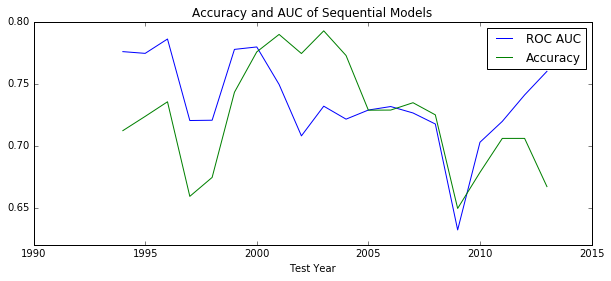

In [39]:
# test with same variables as rf_best
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median',
                  'original_dec_type_string': 'none', 'original_dec_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=100, min_samples_split=5, max_features='sqrt', 
                                max_depth=80, min_samples_leaf=1, random_state=44))

sequential_metrics, average_cfi, sequential_results = fit_sequential_models(
    df, 'granted', cat_features=CAT_FEATURES, num_features=NUM_FEATURES, impute_methods=IMPUTE_METHODS, 
    start_year=1994, end_year=2013, print_charts=False, print_metrics=True)

### Applying weight decay to samples

One reason could be that there are periodic shifts in sentiment such that older data might be less informative to newer cases. Let's attempt to weight recent samples more than older samples. 

In [ ]:
# rf_best + weight decay 0.7 (AUC & Accuracy both up slightly by 0.002)
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median',
                  'original_dec_type_string': 'none', 'original_dec_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=100, min_samples_split=5, max_features='sqrt', 
                                max_depth=80, min_samples_leaf=1, random_state=44))

sequential_metrics, average_cfi, sequential_results = fit_sequential_models(
    df, 'granted', cat_features=CAT_FEATURES, num_features=NUM_FEATURES, impute_methods=IMPUTE_METHODS, 
    start_year=1994, end_year=2013, weight_decay=0.7, print_charts=False, print_metrics=True)

In [ ]:
# tune weight decay 

def tune_weight_decay(df, label, cat_features, num_features, impute_methods, start_year, end_year, weight_decay_alphas):
    results = [] 
    for alpha in weight_decay_alphas: 
        result = {} 
        metrics_summary, _, _ = fit_sequential_models(
            df, 'granted', cat_features=CAT_FEATURES, num_features=NUM_FEATURES, impute_methods=IMPUTE_METHODS, 
            start_year=start_year, end_year=end_year, weight_decay=alpha, print_metrics=False, print_charts=False)
        result['alpha'] = alpha 
        result['average_accuracy'] = metrics_summary['Accuracy'].mean() 
        result['average_roc_auc'] = metrics_summary['ROC AUC'].mean() 
        results.append(result)
    return pd.DataFrame(results)

In [ ]:
# find best alpha
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median',
                  'original_dec_type_string': 'none', 'original_dec_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10, min_samples_split=5, max_features='sqrt', 
                                max_depth=80, min_samples_leaf=1, random_state=44))

weight_decay_tuning = tune_weight_decay(df, 'granted', cat_features=CAT_FEATURES, num_features=NUM_FEATURES, 
                                        impute_methods=IMPUTE_METHODS, start_year=1994, end_year=2013, 
                                        weight_decay_alphas=[.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
weight_decay_tuning

Training model to predict 1994 appeals...
0.5
{'Recall': 0.51215953307392992, 'Log Loss': 0.80410227446233296, 'Precision': 0.66942148760330578, 'ROC AUC': 0.76118816760315766, 'Accuracy': 0.6963110667996012}
Training model to predict 1995 appeals...
0.5
{'Recall': 0.5344444444444445, 'Log Loss': 0.64148560706071289, 'Precision': 0.60834738617200679, 'ROC AUC': 0.76494363929146536, 'Accuracy': 0.73331706721971457}
Training model to predict 1996 appeals...
0.5
{'Recall': 0.47778664538441074, 'Log Loss': 0.8653845424440163, 'Precision': 0.72041716807059764, 'ROC AUC': 0.77111677710679027, 'Accuracy': 0.73282442748091603}
Training model to predict 1997 appeals...
0.5
{'Recall': 0.52649869678540395, 'Log Loss': 0.79121128613888292, 'Precision': 0.60640426951300863, 'ROC AUC': 0.69980964925677303, 'Accuracy': 0.64349037487335359}
Training model to predict 1998 appeals...
0.5
{'Recall': 0.41414812354699437, 'Log Loss': 0.70744276513737736, 'Precision': 0.60740379931807109, 'ROC AUC': 0.69866

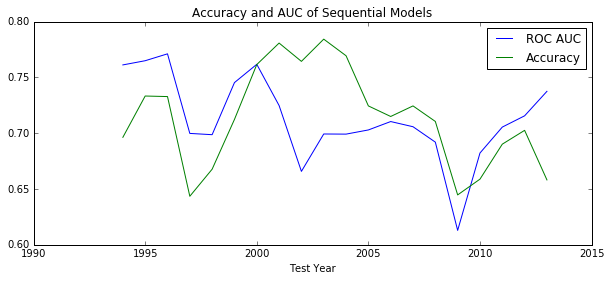

In [64]:
# re-run on best weight decay of 0.5
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median',
                  'original_dec_type_string': 'none', 'original_dec_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10, min_samples_split=5, max_features='sqrt', 
                                max_depth=80, min_samples_leaf=1, random_state=44))

sequential_metrics_wt, average_cfi_wt, sequential_results_wt = fit_sequential_models(
    df, 'granted', cat_features=CAT_FEATURES, num_features=NUM_FEATURES, impute_methods=IMPUTE_METHODS, 
    start_year=1994, end_year=2013, weight_decay=0.5, print_charts=False, print_metrics=True)

In [52]:
# save sequential models as a tuple to pickle 
import pickle
seq_model_pkl_fname = "sequential_random_forest_v0.pkl"
models_object = tuple([sequential_results_wt[year]['model'] for year in sequential_results.keys()]) 
with open(seq_model_pkl_fname, "wb") as f:
    pickle.dump(models_object, f)